In [1]:
from pathlib import Path
import torch
from src.models.models.worldmirror import WorldMirror
from src.utils.inference_utils import extract_load_and_preprocess_images

In [2]:
# --- Setup ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WorldMirror.from_pretrained("/temp/hanmo/models/HunyuanWorld-Mirror").to(device)
model = model.eval()

Loading weights from local directory


In [3]:

# --- Load Data ---
# Load a sequence of N images into a tensor
inputs = {}
inputs['img'] = extract_load_and_preprocess_images(
    Path("./input_images_20251125_151116_632338/images"), # video or directory containing images 
    fps=1, # fps for extracing frames from video
    target_size=518
).to(device)  # [1,N,3,H,W], in [0,1]
# -- Load Priors (Optional) --
# Configure conditioning flags and prior paths
cond_flags = [0, 0, 0]  # [camera_pose, depth, intrinsics]
prior_data = {
    'camera_pose': None,      # Camera pose tensor [1, N, 4, 4]
    'depthmap': None,         # Depth map tensor [1, N, H, W]
    'camera_intrinsics': None # Camera intrinsics tensor [1, N, 3, 3]
}
for idx, (key, data) in enumerate(prior_data.items()):  # add prior data to inputs
    if data is not None:
        cond_flags[idx] = 1
        inputs[key] = data


In [4]:
# --- Inference ---
with torch.no_grad():
    predictions = model(views=inputs, cond_flags=cond_flags)

In [5]:
# Geometry outputs
pts3d_preds, pts3d_conf = predictions["pts3d"][0], predictions["pts3d_conf"][0]       # 3D point cloud in world coordinate: [S, H, W, 3] and point confidence: [S, H, W]
depth_preds, depth_conf = predictions["depth"][0], predictions["depth_conf"][0]       # Z-depth in camera frame: [S, H, W, 1] and depth confidence: [S, H, W]
normal_preds, normal_conf = predictions["normals"][0], predictions["normals_conf"][0] # Surface normal in camera coordinate: [S, H, W, 3] and normal confidence: [S, H, W]

# Camera outputs
camera_poses = predictions["camera_poses"][0]  # Camera-to-world poses (OpenCV convention): [S, 4, 4]
camera_intrs = predictions["camera_intrs"][0]  # Camera intrinsic matrices: [S, 3, 3]
camera_params = predictions["camera_params"][0]   # Camera vector: [S, 9] (translation, quaternion rotation, fov_v, fov_u)

# 3D Gaussian Splatting outputs
splats = predictions["splats"]
means = splats["means"][0].reshape(-1, 3)      # Gaussian means: [N, 3]
opacities = splats["opacities"][0].reshape(-1) # Gaussian opacities: [N]
scales = splats["scales"][0].reshape(-1, 3)    # Gaussian scales: [N, 3]
quats = splats["quats"][0].reshape(-1, 4)      # Gaussian quaternions: [N, 4]
sh = splats["sh"][0].reshape(-1, 1, 3)         # Gaussian spherical harmonics: [N, 1, 3]

## 可视化结果

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 如果你在 notebook 里
%matplotlib inline

# 小工具：把张量转成 numpy 图像 [H,W,3]，范围 0~1
def tensor_to_image(t):
    """
    t: [3,H,W] or [1,3,H,W] torch tensor, in [0,1]
    """
    if t.ndim == 4:
        t = t[0]
    t = t.detach().cpu().clamp(0, 1)
    img = t.permute(1, 2, 0).numpy()
    return img


num frames S = 2


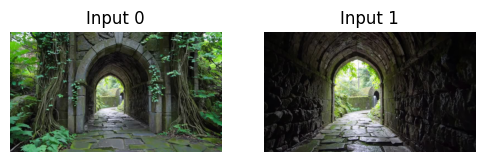

In [9]:
imgs = inputs['img']   # [1,S,3,H,W]
B, S, C, H, W = imgs.shape
print("num frames S =", S)

plt.figure(figsize=(3 * S, 3))
for i in range(S):
    plt.subplot(1, S, i+1)
    img = tensor_to_image(imgs[:, i])  # [H,W,3]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Input {i}")
plt.show()


- 可视化深度图

torch.Size([2, 294, 518, 1]) torch.Size([2, 294, 518])


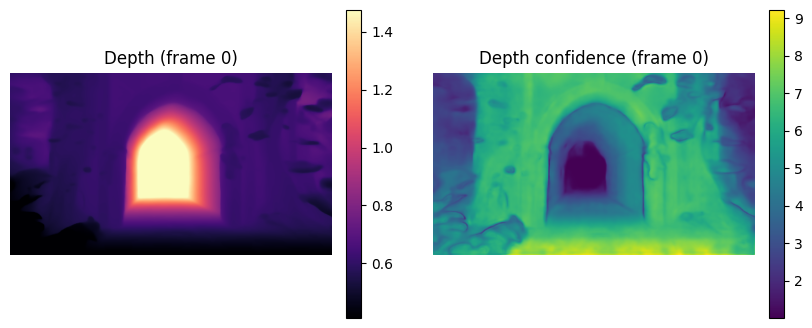

In [10]:
depth_preds = predictions["depth"][0]      # [S, H, W, 1]
depth_conf  = predictions["depth_conf"][0] # [S, H, W]

print(depth_preds.shape, depth_conf.shape)

frame_idx = 0  # 看第几帧

depth = depth_preds[frame_idx, ..., 0].detach().cpu().numpy()  # [H,W]
conf  = depth_conf[frame_idx].detach().cpu().numpy()

# 方便显示：用中位数±3σ裁剪一下
valid = np.isfinite(depth)
d = depth[valid]
d_min, d_max = np.percentile(d, 5), np.percentile(d, 95)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(f"Depth (frame {frame_idx})")
plt.imshow(np.clip(depth, d_min, d_max), cmap='magma')
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.title(f"Depth confidence (frame {frame_idx})")
plt.imshow(conf, cmap='viridis')
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()


- 法线图绘制

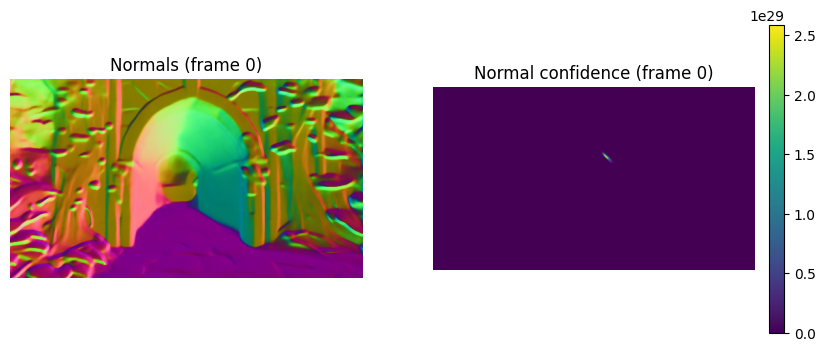

In [11]:
normal_preds = predictions["normals"][0]      # [S,H,W,3]
normal_conf  = predictions["normals_conf"][0] # [S,H,W]

frame_idx = 0

normals = normal_preds[frame_idx].detach().cpu().numpy()   # [-1,1]
conf_n  = normal_conf[frame_idx].detach().cpu().numpy()

# 映射到 [0,1] 方便作为 RGB 显示
normals_vis = (normals + 1.0) / 2.0
normals_vis = np.clip(normals_vis, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(f"Normals (frame {frame_idx})")
plt.imshow(normals_vis)
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Normal confidence (frame {frame_idx})")
plt.imshow(conf_n, cmap='viridis')
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()


- 可视化相机轨迹

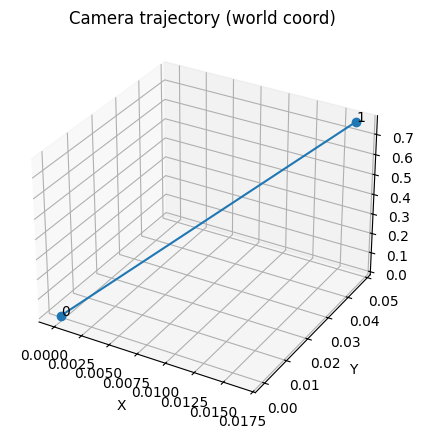

In [12]:
camera_poses = predictions["camera_poses"][0]  # [S,4,4]
camera_intrs = predictions["camera_intrs"][0]  # [S,3,3]

poses = camera_poses.detach().cpu().numpy()

# 取平移部分 t
centers = poses[:, :3, 3]   # [S,3]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(centers[:,0], centers[:,1], centers[:,2], marker='o')
for i in range(centers.shape[0]):
    ax.text(centers[i,0], centers[i,1], centers[i,2], str(i))

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Camera trajectory (world coord)")
plt.show()


## 导出3DGS为ply文件

In [13]:
import os
import torch
from src.utils.save_utils import save_gs_ply, convert_gs_to_ply, process_ply_to_splat

def export_worldmirror_3dgs(predictions, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)

    splats = predictions["splats"]
    means     = splats["means"][0].reshape(-1, 3)
    scales    = splats["scales"][0].reshape(-1, 3)
    rotations = splats["quats"][0].reshape(-1, 4)
    if "sh" in splats:
        rgbs = splats["sh"][0].reshape(-1, 3)
    else:
        rgbs = splats["colors"][0].reshape(-1, 3)
    opacities = splats["opacities"][0].reshape(-1)

    # 确保都是 torch.Tensor（和 app.py 里保持一致）
    for name in ["means", "scales", "rotations", "rgbs", "opacities"]:
        val = locals()[name]
        if not isinstance(val, torch.Tensor):
            locals()[name] = torch.from_numpy(val)

    ply_path = os.path.join(out_dir, "gaussians.ply")
    save_gs_ply(ply_path, means, scales, rotations, rgbs, opacities)

    splat_ply = convert_gs_to_ply(means, scales, rotations, rgbs, opacities)
    splat_path = os.path.join(out_dir, "gaussians.splat")
    process_ply_to_splat(splat_ply, splat_path)

    print("Saved PLY to:", ply_path)
    print("Saved SPLAT to:", splat_path)
    return ply_path, splat_path


In [40]:
export_worldmirror_3dgs(predictions, "./output")

Saved PLY to: ./output/gaussians.ply
Saved SPLAT to: ./output/gaussians.splat


('./output/gaussians.ply', './output/gaussians.splat')

In [17]:
import os
import numpy as np
import torch

from src.utils.visual_util import convert_predictions_to_glb_scene
from src.models.utils.geometry import depth_to_world_coords_points

In [21]:
import os
import numpy as np
import torch
from src.utils.visual_util import convert_predictions_to_glb_scene

raw_preds = predictions  # 你前面跑出来的模型输出

# 1) 图像：inputs['img'] 是 [1, S, 3, H, W]，转成 [S, H, W, 3]
imgs = inputs["img"][0].permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.float32)  # [S,H,W,3]

# 2) world_points 直接用 pts3d（已经是 world 坐标）
world_points = raw_preds["pts3d"][0].detach().cpu().numpy().astype(np.float32)  # [S,H,W,3]

# 3) depth / normal / camera 参数
depth_np   = raw_preds["depth"][0, ..., 0].detach().cpu().numpy().astype(np.float32)     # [S,H,W]
normal_np  = raw_preds["normals"][0].detach().cpu().numpy().astype(np.float32)          # [S,H,W,3]
cam_poses  = raw_preds["camera_poses"][0].detach().cpu().numpy().astype(np.float32)     # [S,4,4]
cam_intrs  = raw_preds["camera_intrs"][0].detach().cpu().numpy().astype(np.float32)     # [S,3,3]

S, H, W, _ = world_points.shape

# 4) 简单的 mask：全部有效，不做天空过滤
final_mask = np.ones((S, H, W), dtype=bool)
sky_mask   = np.zeros((S, H, W), dtype=bool)

# 5) 组装成 convert_predictions_to_glb_scene 期望的格式
pred_for_glb = {
    "images":       imgs,          # [S,H,W,3]
    "world_points": world_points,  # [S,H,W,3]
    "depth":        depth_np,      # [S,H,W]
    "normal":       normal_np,     # [S,H,W,3]
    "final_mask":   final_mask,    # [S,H,W] bool
    "sky_mask":     sky_mask,      # [S,H,W] bool
    "camera_poses": cam_poses,     # [S,4,4]
    "camera_intrs": cam_intrs,     # [S,3,3]
}

# 如果想让 GLB 里也带 3DGS 信息，可以顺便加上（不是必须）
if "splats" in raw_preds:
    spl = raw_preds["splats"]
    splats_dict = {}
    for k, v in spl.items():
        splats_dict[k] = v[0].detach().cpu().numpy()
    pred_for_glb["splats"] = splats_dict

# 6) 调用 GLB 生成函数
scene = convert_predictions_to_glb_scene(
    pred_for_glb,
    filter_by_frames="all",   # 用所有帧；也可以写 "0" 只导第 0 帧
    show_camera=True,
    mask_sky_bg=False,        # 因为我们 sky_mask 全 False
    as_mesh=True,             # 导 mesh
    mask_ambiguous=False
)

os.makedirs("exports", exist_ok=True)
out_path = os.path.join("exports", "worldmirror_scene.glb")
scene.export(out_path)
print("GLB saved to:", out_path)


Building GLB scene
Using Pointmap Branch
Creating mesh for multi-frame data...
GLB Scene built
GLB saved to: exports/worldmirror_scene.glb
